In [1]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq
from Bio import SeqIO

from dwave.system import LeapHybridCQMSampler
from dimod import Binary, ConstrainedQuadraticModel

from codon_hamiltonian import *

## 0. DNA(amino acid) Sequance

In [3]:
tox_human = 'MDVRFYPPPAQPAAAPDAPCLGPSPCLDPYYCNKFDGENMYMSMTEPSQDYVPASQSYPGPSLESEDFNIPPITPPSLPDHSLVHLNEVESGYHSLCHPMNHNGLLPFHPQNMDLPEITVSNMLGQDGTLLSNSISVMPDIRNPEGTQYSSHPQMAAMRPRGQPADIRQQPGMMPHGQLTTINQSQLSAQLGLNMGGSNVPHNSPSPPGSKSATPSPSSSVHEDEGDDTSKINGGEKRPASDMGKKPKTPKKKKKKDPNEPQKPVSAYALFFRDTQAAIKGQNPNATFGEVSKIVASMWDGLGEEQKQVYKKKTEAAKKEYLKQLAAYRASLVSKSYSEPVDVKTSQPPQLINSKPSVFHGPSQAHSALYLSSHYHQQPGMNPHLTAMHPSLPRNIAPKPNNQMPVTVSIANMAVSPPPPLQISPPLHQHLNMQQHQPLTMQQPLGNQLPMQVQSALHSPTMQQGFTLQPDYQTIINPTSTAAQVVTQAMEYVRSGCRNPPPQPVDWNNDYCSSGGMQRDKALYLT'
tox_mouse = 'MDVRFYPPPAQPAAAPAAPCLGPSPCLDPYYCNKFDGENMYMSMTEPSQDYVPASQSYPGPSLESEDFNIPPITPPSLPDHSLVHLNEVESGYHSLCHPMNHNGLLPFHPQTMDLPEITVSNMLGQDGALLSNSISVMQEIGNAEGAQYSSHPQMAAMRPRGQPTDIRQQASMMQPGQLTTINQSQLSAQLGLNMGGTNVAHNSPSPPGSKSATPSPSSSVHEDECEDASKINGGEKRPASDMGKKPKTPKKKKKKDPNEPQKPVSAYALFFRDTQAAIKGQNPNATFGEVSKIVASMWDGLGEEQKQVYKKKTEAAKKEYLKQLAAYRASLVSKSYTDPVDVKTSQPPQLVNSKPSVFHGPSQAHSALYLSSHYHQQPGMTPQLTAMHPSLPRNIAPKPNNQMPVTVSIANMAVSPPPPLQISPPLHQHLSMQQHQSLAMQQPLGSQLPMQVQTALHSPTMQQGFTLQPDYQTIINPTSTAAQVVTQAMEYVRSGCRNPPPQPVDWSTDYCSSGGMQRDKALYLT'
wnt11_human = 'MRARPQVCEALLFALALQTGVCYGIKWLALSKTPSALALNQTQHCKQLEGLVSAQVQLCRSNLELMHTVVHAAREVMKACRRAFADMRWNCSSIELAPNYLLDLERGTRESAFVYALSAAAISHAIARACTSGDLPGCSCGPVPGEPPGPGNRWGGCADNLSYGLLMGAKFSDAPMKVKKTGSQANKLMRLHNSEVGRQALRASLEMKCKCHGVSGSCSIRTCWKGLQELQDVAADLKTRYLSATKVVHRPMGTRKHLVPKDLDIRPVKDSELVYLQSSPDFCMKNEKVGSHGTQDRQCNKTSNGSDSCDLMCCGRGYNPYTDRVVERCHCKYHWCCYVTCRRCERTVERYVCK'

In [4]:
len(tox_human), len(tox_mouse), len(wnt11_human)

(526, 526, 354)

or

In [5]:
records_gene = SeqIO.read("./TOX_human_datasets/ncbi_dataset/data/gene.fna", "fasta")
records_rna = SeqIO.read("./TOX_human_datasets/ncbi_dataset/data/rna.fna", "fasta")
records_protein = SeqIO.read("./TOX_human_datasets/ncbi_dataset/data/protein.faa", "fasta")

In [6]:
tox_human_dna = 'ATGGACGTAAGATTTTATCCACCTCCAGCCCAGCCCGCCGCTGCGCCCGACGCTCCCTGTCTGGGACCTTCTCCCTGCCTGGACCCCTACTATTGCAACAAGTTTGACGGTGAGAACATGTATATGAGCATGACAGAGCCGAGCCAGGACTATGTGCCAGCCAGCCAGTCCTACCCTGGTCCAAGCCTGGAAAGTGAAGACTTCAACATTCCACCAATTACTCCTCCTTCCCTCCCAGACCACTCGCTGGTGCACCTGAATGAAGTTGAGTCTGGTTACCATTCTCTGTGTCACCCCATGAACCATAATGGCCTGCTACCATTTCATCCACAAAACATGGACCTCCCTGAAATCACAGTCTCCAATATGCTGGGCCAGGATGGAACACTGCTTTCTAATTCCATTTCTGTGATGCCAGATATACGAAACCCAGAAGGAACTCAGTACAGTTCCCATCCTCAGATGGCAGCCATGAGACCAAGGGGCCAGCCTGCAGACATCAGGCAGCAGCCAGGAATGATGCCACATGGCCAGCTGACTACCATTAACCAGTCACAGCTAAGTGCTCAACTTGGTTTGAATATGGGAGGAAGCAATGTTCCCCACAACTCACCATCTCCACCTGGAAGCAAGTCTGCAACTCCTTCACCATCCAGTTCAGTGCATGAAGATGAAGGCGATGATACCTCTAAGATCAATGGTGGAGAGAAGCGGCCTGCCTCTGATATGGGGAAAAAACCAAAAACTCCCAAAAAGAAGAAGAAGAAGGATCCCAATGAGCCCCAGAAGCCTGTGTCTGCCTATGCGTTATTCTTTCGTGATACTCAGGCCGCCATCAAGGGCCAAAATCCAAACGCTACCTTTGGCGAAGTCTCTAAAATTGTGGCTTCAATGTGGGACGGTTTAGGAGAAGAGCAAAAACAGGTCTATAAAAAGAAAACCGAGGCTGCGAAGAAGGAGTACCTGAAGCAACTCGCAGCATACAGAGCCAGCCTTGTATCCAAGAGCTACAGTGAACCTGTTGACGTGAAGACATCTCAACCTCCTCAGCTGATCAATTCGAAGCCGTCGGTGTTCCATGGGCCCAGCCAGGCCCACTCGGCCCTGTACCTAAGTTCCCACTATCACCAACAACCGGGAATGAATCCTCACCTAACTGCCATGCATCCTAGTCTCCCCAGGAACATAGCCCCCAAGCCGAATAACCAAATGCCAGTGACTGTCTCTATAGCAAACATGGCTGTGTCCCCTCCTCCTCCCCTCCAGATCAGCCCGCCTCTTCACCAGCATCTCAACATGCAGCAGCACCAGCCGCTCACCATGCAGCAGCCCCTTGGGAACCAGCTCCCCATGCAGGTCCAGTCTGCCTTACACTCACCCACCATGCAGCAAGGATTTACTCTTCAACCCGACTATCAGACTATTATCAATCCTACATCTACAGCTGCACAAGTTGTCACCCAGGCAATGGAGTATGTGCGTTCGGGGTGCAGAAATCCTCCCCCACAACCGGTGGACTGGAATAACGACTACTGCAGTAGTGGGGGCATGCAGAGGGACAAAGCACTGTACCTTACT'
tox_mouse_dna = 'ATGGACGTAAGATTTTATCCTCCTCCAGCCCAGCCCGCTGCTGCGCCCGCCGCTCCTTGTCTGGGACCTTCTCCCTGCCTGGACCCCTACTATTGCAACAAGTTTGACGGGGAGAACATGTATATGAGCATGACAGAGCCGAGCCAGGACTATGTGCCAGCCAGCCAGTCCTACCCTGGACCAAGTCTGGAAAGTGAAGATTTTAACATCCCACCCATCACGCCTCCCTCCCTCCCTGACCACTCTCTGGTGCACCTGAATGAGGTAGAATCCGGTTACCACTCTCTGTGTCACCCCATGAATCACAATGGCCTGCTCCCGTTCCATCCACAAACCATGGACCTGCCAGAGATCACGGTGTCCAACATGCTGGGCCAAGATGGCGCACTGCTCTCCAATTCCATCTCTGTGATGCAAGAGATTGGGAACGCAGAAGGAGCTCAGTACAGCTCCCATCCTCAGATGGCAGCCATGAGGCCGAGAGGCCAGCCTACAGACATCAGACAGCAGGCAAGCATGATGCAGCCCGGCCAGCTGACCACCATCAACCAGTCGCAGCTGAGCGCACAGTTGGGCTTGAACATGGGAGGAACCAATGTGGCCCACAACTCCCCTTCTCCACCCGGGAGCAAGTCTGCAACCCCTTCCCCATCCAGCTCAGTGCATGAGGATGAGTGTGAGGATGCCTCCAAGATCAATGGAGGAGAGAAGCGGCCTGCCTCTGATATGGGGAAAAAACCCAAAACTCCCAAGAAGAAGAAGAAGAAGGATCCTAATGAGCCCCAGAAGCCTGTGTCTGCCTATGCTTTGTTCTTTCGTGATACCCAGGCTGCCATTAAGGGCCAGAATCCAAATGCTACTTTTGGTGAAGTATCGAAGATTGTGGCATCAATGTGGGATGGCCTAGGAGAAGAACAGAAACAGGTCTATAAGAAGAAAACCGAGGCTGCAAAGAAGGAATACCTGAAGCAGCTAGCAGCATACAGAGCCAGCCTTGTATCCAAGAGCTACACTGATCCTGTTGATGTTAAGACATCTCAGCCACCCCAGCTGGTCAACTCAAAGCCGTCAGTATTCCATGGGCCCAGCCAGGCCCACTCAGCTCTGTACCTAAGTTCTCACTATCACCAACAACCAGGAATGACTCCTCAGCTCACCGCCATGCATCCGAGCCTCCCCAGAAACATAGCACCTAAGCCCAATAACCAAATGCCAGTGACTGTCTCCATAGCCAACATGGCTGTGTCCCCACCACCGCCCCTTCAGATCAGCCCACCTCTTCATCAGCATCTCAGCATGCAGCAGCATCAGTCGCTTGCCATGCAGCAGCCCCTTGGGAGTCAGCTCCCCATGCAGGTCCAGACTGCCTTACACTCGCCCACCATGCAGCAAGGATTTACTCTTCAACCCGACTATCAGACTATTATCAACCCTACATCTACAGCTGCACAAGTTGTCACCCAAGCGATGGAGTACGTGCGTTCTGGGTGCAGAAATCCGCCCCCACAGCCCGTGGACTGGAGTACCGACTACTGCAGTAGTGGGGGCATGCAGAGGGACAAAGCGCTGTATCTCACC'
wnt11_human_dna = 'ATGAGGGCGCGGCCGCAGGTCTGCGAGGCGCTGCTCTTCGCCCTGGCGCTCCAGACCGGCGTGTGCTATGGCATCAAGTGGCTGGCGCTGTCCAAGACACCATCGGCCCTGGCACTGAACCAGACGCAACACTGCAAGCAGCTGGAGGGTCTGGTGTCTGCACAGGTGCAGCTGTGCCGCAGCAACCTGGAGCTCATGCACACGGTGGTGCACGCCGCCCGCGAGGTCATGAAGGCCTGTCGCCGGGCCTTTGCCGACATGCGCTGGAACTGCTCCTCCATTGAGCTCGCCCCCAACTATTTGCTTGACCTGGAGAGAGGGACCCGGGAGTCGGCCTTCGTGTATGCGCTGTCGGCCGCCGCCATCAGCCACGCCATCGCCCGGGCCTGCACCTCCGGCGACCTGCCCGGCTGCTCCTGCGGCCCCGTCCCAGGTGAGCCACCCGGGCCCGGGAACCGCTGGGGAGGATGTGCGGACAACCTCAGCTACGGGCTCCTCATGGGGGCCAAGTTTTCCGATGCTCCTATGAAGGTGAAAAAAACAGGATCCCAAGCCAATAAACTGATGCGTCTACACAACAGTGAAGTGGGGAGACAGGCTCTGCGCGCCTCTCTGGAAATGAAGTGTAAGTGCCATGGGGTGTCTGGCTCCTGCTCCATCCGCACCTGCTGGAAGGGGCTGCAGGAGCTGCAGGATGTGGCTGCTGACCTCAAGACCCGATACCTGTCGGCCACCAAGGTAGTGCACCGACCCATGGGCACCCGCAAGCACCTGGTGCCCAAGGACCTGGATATCCGGCCTGTGAAGGACTCGGAACTCGTCTATCTGCAGAGCTCACCTGACTTCTGCATGAAGAATGAGAAGGTGGGCTCCCACGGGACACAAGACAGGCAGTGCAACAAGACATCCAACGGAAGCGACAGCTGCGACCTTATGTGCTGCGGGCGTGGCTACAACCCCTACACAGACCGCGTGGTCGAGCGGTGCCACTGTAAGTACCACTGGTGCTGCTACGTCACCTGCCGCAGGTGTGAGCGTACCGTGGAGCGCTATGTCTGCAAG'

## 1. TOX_HUMAN OS=h_sapiens, OX=9606

In [7]:
name = 'TOX_HUMAN'
aa_seq = tox_human
weight_params = {'cub_h1': 1, 'cub_h2': 1, 'cpub_h1': 1, 'cpub_h2': 1, 'rep_nuc': 1, 'rho_T': 0.6, 'B_rho': 0.05}
hosts = ['e_coli', 'h_sapiens']

In [8]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=False)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

47 feasible solutions of 116.


'ATGGATGTGCGCTTCTATCCGCCGCCGGCGCAGCCAGCAGCAGCACCTGATGCACCTTGTCTCGGTCCTTCTCCTTGTCTGGATCCTTACTACTGCAACAAGTTCGATGGCGAGAACATGTACATGAGCATGACAGAGCCTTCTCAGGACTATGTGCCTGCATCTCAGAGCTATCCTGGTCCTTCTCTGGAGAGTGAGGACTTCAACATTCCACCAATCACGCCGCCGTCGCTGCCTGATCACTCGCTGGTGCATCTGAATGAAGTAGAGAGCGGCTATCACTCGCTGTGTCATCCAATGAACCACAATGGCCTGCTGCCGTTCCATCCACAGAACATGGATCTGCCGGAGATCACTGTCAGCAACATGCTCGGCCAGGATGGCACGCTGCTGAGCAACAGCATCAGCGTGATGCCTGACATCCGCAATCCAGAAGGCACTCAGTACAGCAGTCATCCACAGATGGCAGCGATGCGTCCGCGCGGCCAGCCTGCTGATATCAGACAGCAGCCTGGCATGATGCCACATGGTCAGCTGACTACTATCAACCAGAGTCAGCTCTCTGCTCAGCTCGGCCTGAACATGGGCGGCAGCAATGTGCCGCACAACAGTCCTTCACCACCAGGCAGCAAGTCTGCTACACCTTCACCAAGCAGCAGCGTGCATGAGGATGAAGGTGATGACACATCTAAGATCAACGGCGGCGAGAAGCGTCCTGCATCTGACATGGGCAAGAAGCCGAAGACGCCGAAGAAGAAGAAGAAGAAGGATCCTAATGAGCCGCAGAAGCCTGTCAGTGCATATGCGCTGTTCTTCCGTGACACTCAGGCTGCTATCAAGGGCCAGAATCCTAATGCCACCTTCGGTGAAGTCAGCAAGATCGTCGCGAGCATGTGGGATGGCCTTGGTGAAGAGCAGAAGCAGGTCTACAAGAAGAAGACAGAGGCTGCTAAGAAGGAGTATCTGAAGCAGCTGGCAGCATATCGCGCGTCGCTGGTC

DNA name: TOX_HUMAN                                           
                     cub_h1 cub_h2 cpub_h1 cpub_h2 rep_nuc rho_T B_rho
Weights                 1.0    1.0     1.0     1.0     1.0   0.6  0.05

,Optimal Codon Seq
Similarity to ref_codon,0.778200
Effective number of codons,36.242462
GC,56.400507
GC3,65.779468


,e_coli,h_sapiens
CAI,0.69094,0.772627
CPB,0.07310,0.046008


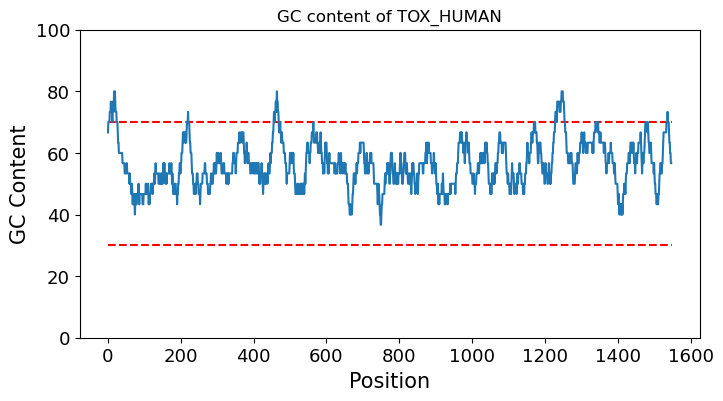

In [9]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=tox_human_dna)

## 2. TOX_MOUSE OS=m_musculus, OX=10090

In [10]:
name = 'TOX_MOUSE'
aa_seq = tox_mouse
weight_params = {'cub_h1': 1, 'cub_h2': 0, 'cpub_h1': 0, 'cpub_h2': 0, 'rep_nuc': 1, 'rho_T': 0.6, 'B_rho': 0.05}
hosts = ['e_coli', 'm_musculus']
opt_codon_seq = 'ATGGATGTAAGGTTTTATCCTCCCCCAGCTCAGCCAGCGGCCGCTCCGGCGGCGCCGTGCCTGGGCCCATCGCCGTGTCTGGATCCGTATTACTGCAATAAATTCGATGGTGAGAACATGTATATGTCCATGACCGAGCCGAGCCAGGACTACGTTCCGGCGAGCCAGAGCTACCCGGGTCCGAGCCTGGAATCCGAAGACTTCAACATTCCGCCGATCACGCCACCGTCGCTGCCGGACCACAGTCTGGTGCATCTGAACGAGGTGGAAAGCGGTTATCATTCCCTTTGCCATCCGATGAATCACAATGGTCTCCTGCCGTTCCACCCTCAAACGATGGATCTGCCGGAGATCACCGTTAGCAACATGCTGGGCCAGGACGGCGCCCTGTTGTCTAACTCCATCAGCGTCATGCAAGAAATTGGTAATGCGGAAGGTGCACAATATAGCAGCCACCCGCAGATGGCTGCTATGCGTCCGCGCGGTCAGCCGACCGACATCCGTCAGCAAGCCTCTATGATGCAACCGGGCCAGCTGACTACAATTAACCAGTCCCAGCTGAGCGCTCAATTGGGTTTGAATATGGGAGGCACCAATGTGGCGCACAACTCCCCGTCTCCGCCGGGCAGCAAGAGCGCCACCCCGTCCCCGTCGTCTAGCGTGCACGAGGACGAATGTGAAGATGCAAGCAAGATTAACGGCGGCGAGAAGCGCCCAGCGTCTGATATGGGTAAAAAGCCGAAAACCCCAAAAAAGAAGAAGAAGAAGGACCCGAACGAGCCGCAGAAACCGGTGTCTGCGTACGCACTGTTCTTTAGAGATACCCAGGCTGCGATTAAAGGTCAAAACCCGAACGCCACCTTTGGTGAGGTTTCAAAGATCGTGGCGAGCATGTGGGATGGCTTGGGCGAGGAACAGAAACAAGTTTATAAAAAGAAGACCGAGGCCGCGAAAAAAGAATACTTAAAACAGCTGGCAGCGTATCGTGCTTCACTGGTCAGCAAAAGCTACACCGACCCGGTTGATGTTAAAACGAGCCAGCCGCCACAATTGGTCAATTCTAAGCCGTCAGTGTTTCATGGTCCGTCCCAAGCGCACAGCGCGTTGTACCTAAGCAGCCATTATCACCAGCAGCCGGGTATGACCCCGCAACTGACTGCGATGCATCCGTCCTTACCCCGCAACATCGCGCCTAAGCCAAACAACCAGATGCCGGTCACGGTGTCTATCGCCAATATGGCAGTTAGCCCTCCGCCTCCGCTGCAGATTAGCCCACCGCTTCACCAACATCTGAGCATGCAGCAGCACCAGTCCCTGGCAATGCAACAGCCGTTGGGCTCGCAATTGCCGATGCAAGTTCAGACCGCGCTGCACTCACCAACGATGCAACAAGGTTTTACCCTGCAACCGGACTACCAGACCATTATCAACCCGACCTCCACCGCGGCGCAGGTAGTTACCCAGGCGATGGAATACGTACGTAGCGGGTGCCGTAATCCGCCGCCTCAACCGGTGGACTGGAGCACTGATTACTGCAGCTCAGGCGGTATGCAGCGTGACAAAGCACTTTATCTGACC'

In [11]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1])
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

92 feasible solutions of 117.


'ATGGATGTGCGCTTCTATCCGCCGCCGGCGCAGCCGGCAGCAGCGCCGGCAGCGCCGTGTCTCGGTCCGAGTCCGTGTCTCGATCCGTACTACTGCAACAAGTTCGATGGCGAGAACATGTATATGAGCATGACTGAGCCGTCGCAGGACTATGTGCCGGCGTCTCAGAGCTATCCAGGTCCGTCGCTCGAGAGCGAGGACTTCAACATTCCGCCGATCACGCCGCCGAGTCTGCCGGATCATAGTCTCGTGCATCTGAACGAAGTCGAGAGCGGCTATCATAGTCTGTGTCATCCGATGAACCATAACGGCCTGCTGCCGTTCCATCCGCAGACGATGGATCTGCCGGAGATCACTGTGAGCAACATGCTCGGCCAGGATGGCGCGCTGCTGAGCAACAGCATCAGCGTGATGCAGGAGATCGGCAACGCGGAAGGCGCGCAGTATAGCTCTCATCCGCAGATGGCAGCGATGCGTCCGCGCGGCCAGCCGACTGATATACGTCAGCAGGCGAGCATGATGCAGCCAGGCCAGCTGACGACGATCAACCAGTCTCAGCTGAGCGCGCAGCTCGGCCTGAACATGGGCGGCACCAACGTCGCGCATAACTCTCCGTCGCCGCCAGGCAGCAAGAGCGCGACGCCGTCTCCGAGCAGCAGCGTGCATGAGGATGAGTGCGAGGATGCGAGCAAGATTAACGGCGGCGAGAAGCGTCCGGCGAGCGATATGGGCAAGAAGCCGAAGACGCCGAAGAAGAAGAAGAAGAAGGATCCGAACGAACCGCAGAAGCCGGTGAGCGCGTATGCGCTGTTCTTCCGCGATACGCAGGCAGCGATCAAGGGCCAGAATCCGAACGCGACGTTCGGCGAAGTGAGCAAGATCGTCGCGAGCATGTGGGATGGCTTAGGCGAAGAGCAGAAGCAGGTGTATAAGAAGAAGACTGAGGCAGCGAAGAAGGAGTATCTGAAGCAGCTCGCAGCGTATCGCGCGTCTCTCGTG

,Optimal Codon Seq
Similarity to ref_codon,0.759823
Effective number of codons,28.368668
GC,61.153359
GC3,78.897338


,e_coli,m_musculus
CAI,0.786549,0.669005
CPB,-0.072945,-0.097432


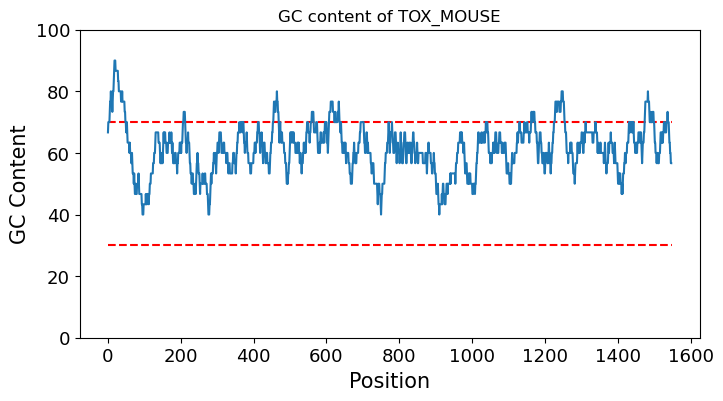

In [12]:
dp_metrics(name, opt_codon_seq, hosts, ref_codon=tox_mouse_dna)# weight_params=weight_params, 

## 3. WNT11_HUMAN OS=h_sapiens, OX=9606

In [13]:
name = 'WNT11_HUMAN'
aa_seq = wnt11_human
weight_params = {'cub_h1': 2, 'cub_h2': 1, 'cpub_h1': 1.8, 'cpub_h2': 1.8, 'rep_nuc': 1, 'rho_T': 0.51, 'B_rho': 0.05}
hosts = ['e_coli', 'h_sapiens']

In [14]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1])
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

DNA name: WNT11_HUMAN                                           
                       cub_h1 cub_h2 cpub_h1 cpub_h2 rep_nuc rho_T B_rho
Weights                   2.0    1.0     1.8     1.8     1.0  0.51  0.05

,Optimal Codon Seq
Similarity to ref_codon,0.806026
Effective number of codons,36.098641
GC,55.838041
GC3,58.757062


,e_coli,h_sapiens
CAI,0.728445,0.769771
CPB,0.062773,0.077584


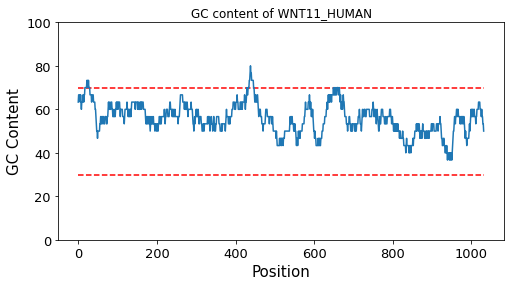

: 

In [ ]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=wnt11_human_dna) #

## 4. SPIKE_SARS2 Spike glycoprotein <br>
### OS=Severe acute respiratory syndrome coronavirus 2 OX=2697049

CAI(human): 0.70 $\pm$ 0.01

In [2]:
sars_cov_protein = SeqIO.read("./SARS_Cov2_glycoprotein_YP_009724390_datasets/protein.faa", "fasta").seq
sars_cov_gene = SeqIO.read("./SARS_Cov2_glycoprotein_YP_009724390_datasets/gene.fna", "fasta").seq
len(sars_cov_protein)

1273

In [7]:
name = 'SPIKE_SARS2 Spike glycoprotein'
aa_seq = sars_cov_protein #[:700]
weight_params = {'cub_h1': 1, 'cpub_h1': 1, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 0.75, 'rho_T': 0.5, 'B_rho': 0.4}
hosts = ['h_sapiens', 'sars_cov2']
opt_codon_seq = 'ATGTTCGTGTTCCTGGTGCTGCTGCCTCTGGTGAGCAGCCAGTGTGTGAACCTGACTACTAGAACACAGCTGCCTCCAGCCTACACCAACAGCTTCACTAGAGGAGTGTACTATCCAGACAAGGTGTTCAGATCATCTGTGCTGCACAGCACACAGGATCTCTTCCTGCCATTCTTCAGCAATGTGACATGGTTCCATGCTATACATGTGTCTGGAACCAATGGAACCAAGCGCTTCGACAATCCTGTGCTGCCATTCAATGATGGAGTGTACTTCGCCAGCACAGAGAAGTCCAACATCATCAGAGGATGGATCTTCGGCACCACTCTGGACAGCAAGACTCAGTCTCTGCTGATCGTCAACAATGCTACTAATGTCGTGATCAAGGTGTGTGAATTCCAGTTCTGCAATGACCCATTCCTGGGTGTGTACTATCATAAGAATAACAAGTCTTGGATGGAGAGTGAGTTCAGAGTGTACAGCAGTGCCAACAACTGTACATTCGAGTATGTGTCTCAGCCATTCCTGATGGATCTGGAGGGCAAGCAGGGCAACTTCAAGAACCTGAGAGAGTTCGTGTTCAAGAATATTGATGGATACTTCAAGATCTACAGCAAGCATACACCTATCAACCTGGTGAGAGATCTGCCTCAAGGATTCTCTGCTCTGGAGCCACTGGTGGATCTGCCTATTGGCATCAACATCACTAGATTCCAGACTCTGCTGGCTCTGCACAGAAGCTACCTCACACCTGGAGACAGCAGCAGCGGCTGGACAGCTGGTGCTGCTGCTTACTATGTTGGCTATCTGCAGCCAAGGACCTTCCTGCTGAAGTATAATGAGAATGGAACCATCACAGATGCTGTGGACTGTGCTCTGGATCCTCTGAGTGAGACCAAGTGCACACTGAAGTCCTTCACTGTGGAGAAGGGCATCTATCAGACAAGCAACTTCAGAGTGCAGCCTACAGAGAGCATCGTGCGCTTCCCTAACATCACTAACCTGTGTCCATTCGGCGAGGTGTTCAATGCTACAAGATTTGCATCTGTGTATGCCTGGAATAGGAAGCGCATCAGCAACTGTGTGGCTGACTATAGTGTGCTCTACAACAGTGCCTCCTTCTCCACCTTCAAGTGCTATGGAGTGTCTCCAACCAAGCTGAATGATCTCTGCTTCACCAATGTGTATGCTGACAGCTTCGTGATCAGAGGAGATGAGGTGAGACAGATAGCTCCTGGTCAGACAGGCAAGATTGCTGACTACAACTACAAGCTGCCTGATGACTTCACAGGCTGTGTCATCGCCTGGAACAGCAACAACCTGGACAGCAAGGTTGGAGGAAATTATAATTATCTGTACAGACTCTTCAGGAAGAGCAATCTGAAGCCATTCGAGAGAGATATCAGCACAGAGATCTATCAGGCTGGCAGCACACCATGTAATGGTGTGGAGGGCTTCAACTGCTACTTCCCTCTGCAGAGCTATGGCTTCCAGCCAACTAATGGTGTTGGCTATCAGCCTTACAGAGTGGTGGTGCTCAGCTTCGAGCTGCTGCATGCTCCAGCTACTGTGTGTGGACCTAAGAAGAGCACCAACCTGGTGAAGAATAAGTGTGTCAACTTCAACTTCAATGGCCTGACTGGAACAGGAGTGCTCACAGAGAGCAACAAGAAGTTCCTGCCATTCCAGCAGTTCGGCAGAGACATAGCTGACACAACAGATGCTGTGAGAGATCCTCAGACACTGGAGATCCTGGACATCACACCTTGTAGCTTCGGCGGCGTGTCTGTCATCACACCAGGCACCAACACATCTAATCAAGTGGCAGTGCTCTATCAGGATGTGAACTGCACAGAGGTGCCTGTGGCAATTCATGCTGACCAGCTGACACCAACCTGGAGAGTGTACAGTACTGGAAGTAATGTCTTCCAGACAAGAGCTGGCTGCCTGATTGGTGCTGAGCACGTGAATAATTCATATGAGTGTGATATTCCAATTGGAGCTGGCATCTGTGCTAGCTATCAGACACAGACTAATTCTCCAAGAAGAGCTAGATCTGTGGCATCTCAGAGCATCATCGCATATACTATGTCTCTGGGAGCTGAGAATTCTGTGGCCTACAGCAACAACAGCATCGCCATTCCAACCAACTTCACCATCTCTGTGACTACAGAGATCCTGCCTGTGTCTATGACCAAGACATCAGTGGACTGCACTATGTACATCTGTGGAGACAGCACAGAGTGTAGCAACCTGCTGCTGCAGTATGGCAGCTTCTGCACACAGCTGAACAGAGCTCTGACTGGAATTGCTGTGGAGCAGGACAAGAACACACAGGAAGTCTTCGCTCAGGTGAAGCAGATCTATAAGACACCTCCAATTAAGGACTTCGGCGGCTTCAACTTCTCACAGATCTTGCCAGATCCTTCTAAGCCTTCTAAGCGCAGCTTCATCGAGGATCTGCTCTTCAACAAGGTGACACTGGCTGATGCTGGCTTCATCAAGCAGTATGGAGACTGTCTTGGAGATATAGCAGCTCGAGATCTGATCTGTGCTCAGAAGTTCAATGGCCTGACTGTGCTGCCTCCTCTGCTGACAGATGAGATGATAGCACAGTACACATCAGCTCTGCTGGCTGGAACCATCACATCTGGCTGGACATTCGGCGCTGGAGCTGCTCTGCAGATTCCATTCGCCATGCAGATGGCATATCGCTTCAATGGAATTGGTGTGACACAGAATGTGCTGTATGAGAACCAGAAGCTGATAGCTAATCAGTTCAACAGTGCTATTGGCAAGATTCAGGATTCTCTGAGCAGCACAGCATCTGCTCTTGGCAAGCTGCAGGACGTGGTGAATCAGAATGCTCAGGCTCTGAATACACTGGTGAAGCAGCTCAGCAGCAACTTCGGAGCCATCAGCTCTGTGCTGAATGATATCCTGAGCAGACTGGACAAGGTGGAGGCTGAGGTGCAGATCGACAGACTCATCACTGGAAGGCTGCAGTCTCTGCAGACATATGTCACTCAGCAGCTCATCAGAGCTGCTGAGATCAGAGCATCTGCCAACCTGGCTGCCACCAAGATGTCTGAGTGTGTGCTGGGCCAGAGCAAGAGAGTGGACTTCTGCGGCAAGGGCTACCACCTGATGAGCTTCCCTCAGAGTGCTCCTCATGGCGTCGTCTTCCTGCACGTGACATATGTGCCTGCTCAGGAGAAGAACTTCACCACAGCACCTGCCATCTGTCATGATGGCAAGGCTCACTTCCCAAGAGAAGGAGTCTTCGTGTCTAATGGCACACACTGGTTCGTGACACAGAGAAACTTCTATGAACCTCAGATCATCACTACAGATAACACCTTCGTGTCTGGCAACTGTGATGTGGTCATCGGCATCGTGAATAATACTGTCTATGATCCACTGCAGCCTGAGCTGGACAGCTTCAAGGAGGAGCTGGATAAGTACTTCAAGAACCACACATCTCCAGATGTGGATCTTGGAGACATCAGTGGCATCAATGCATCTGTGGTCAACATCCAGAAGGAGATAGATAGACTCAATGAGGTGGCCAAGAATCTCAATGAGTCTCTCATCGATCTGCAGGAGCTGGGCAAGTATGAGCAGTACATCAAGTGGCCTTGGTACATCTGGCTGGGCTTCATTGCTGGACTCATCGCCATCGTGATGGTGACCATCATGCTGTGCTGCATGACTAGCTGCTGCAGCTGCCTGAAGGGCTGCTGCAGCTGTGGCAGCTGCTGTAAGTTCGATGAGGACGACTCTGAGCCTGTGCTGAAGGGCGTGAAGCTGCACTATACT'
len(opt_codon_seq)

3819

In [ ]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=False)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

DNA name: SPIKE_SARS2 Spike glycoprotein                         \
                                          cub_h1 cpub_h1 cub_h2 cpub_h2   
Weights                                      1.0     1.0    0.0     0.0   

                             
        rep_nuc rho_T B_rho  
Weights    0.75   0.5   0.4

,Optimal Codon Seq
Similarity to ref_codon,0.747578
Effective number of codons,32.446666
GC,50.039277
GC3,61.586803


,h_sapiens,sars_cov2
CAI,0.884450,0.481679
CPB,0.078715,-2.705615


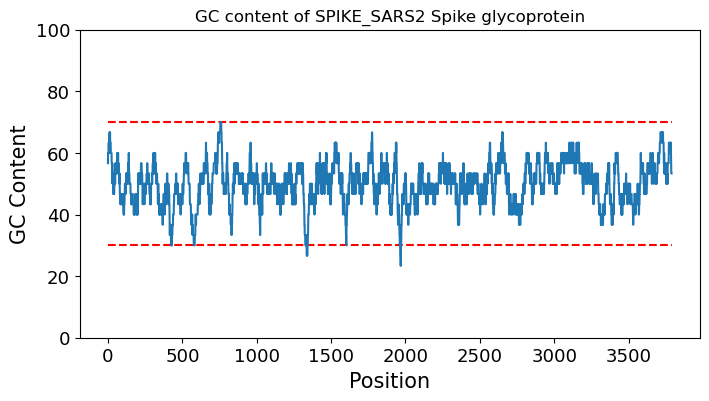

In [8]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=sars_cov_gene[:-3]) #

In [1]:
#file = open('spike_glycoprotein_for_human6.txt', "a")
#a = file.write(opt_codon_seq)
#file.close()

NameError: name 'opt_codon_seq' is not defined

For Human,

1. GC ~ mean 40~50%?
2. GC3 ~ mean 70-80%
3. ENC ~ 45?
4. CAI ~ 0.78~0.8
5. CPB ~ 0.08?

## 5. Insulin_sequence <br>
Homo sapiens chromosome 1_On '-' strand of Chromosome 11 (NC_000011.10)

In [2]:
insulin_human_dna = 'ATGGCCCTGTGGATGCGCCTCCTGCCCCTGCTGGCGCTGCTGGCCCTCTGGGGACCTGACCCAGCCGCAGCCTTTGTGAACCAACACCTGTGCGGCTCACACCTGGTGGAAGCTCTCTACCTAGTGTGCGGGGAACGAGGCTTCTTCTACACACCCAAGACCCGCCGGGAGGCAGAGGACCTGCAGGTGGGGCAGGTGGAGCTGGGCGGGGGCCCTGGTGCAGGCAGCCTGCAGCCCTTGGCCCTGGAGGGGTCCCTGCAGAAGCGTGGCATTGTGGAACAATGCTGTACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACTAG'
insulin_human_protein = 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
len(insulin_human_protein)

110

In [3]:
name = 'Insulin'
aa_seq = insulin_human_protein
weight_params = {'cub_h1': 0.02, 'cpub_h1': 0.6, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 1, 'rho_T': 0.46, 'B_rho': 0.048}
hosts = ['e_coli', 'h_sapiens']
#opt_codon_seq = 

In [4]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=False)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

SolverFailureError: Problem not accepted because user has insufficient remaining solver access time in project yXwP.

DNA name: Insulin                                            
                   cub_h1 cpub_h1 cub_h2 cpub_h2 rep_nuc rho_T  B_rho
Weights              0.02     0.6    0.0     0.0     1.0  0.46  0.048

,Optimal Codon Seq
Similarity to ref_codon,0.730303
Effective number of codons,32.514179
GC,50.606061
GC3,38.181818


,e_coli,h_sapiens
CAI,0.399218,0.578754
CPB,0.158323,-0.071552


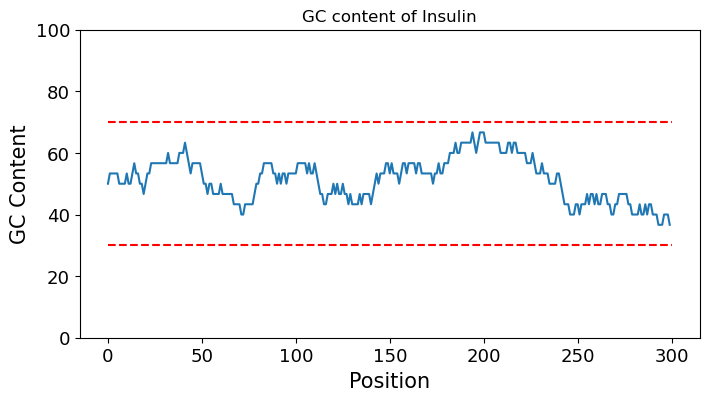

In [34]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=insulin_human_dna[:-3])

In [35]:
file = open('insulin_for_ecoli1.txt', "a")
a = file.write(opt_codon_seq)
file.close()

For E. Coli,

1. GC ~ mean 50.4 ~ 50.8%?
2. GC3 ~ mean 40~60 max 0 5? 
3. ENC ~ 30~40
4. CAI ~ 0.38~0.40?
5. CPB ~ 0.08?

## 6. Recombinant Insulin <br>
human prepromini insulin


In [20]:
recombinant_insulin_ecoli_dna = 'ATGAACTTCCTCAAAAGCTTCCCCTTTTTTGCCTTCCTTTGTTTTGGCCAATACTTTGTAGCTGTTACTCATGCTTTTGTGAACCAACACCTGTGGGCTCACACCTGGTGGAAGCTCTCTACCTAGTGTGCGGGGAACGAGGCTTCTTCTACACACCCAAGGCTCTAAGGGCATTGTGGAACAATGCTGTACCAGCATCTGCTCCCTCTACCAGCTGGAGAACTACTGCAACAGAAGACATCATCATCATCATCATAAGGATGAACTTTGA'
recombinant_insulin_ecoli_protain = 'MNFLKSFPFFAFLCFGQYFVAVTHAFVNQHLCGSHLVEALYLVCGERGFFYTPKAAKGIVEQCCTSICSLYQLENYCNRRHHHHHHKDEL'
print(len(recombinant_insulin_ecoli_protain), len(recombinant_insulin_ecoli_dna))

90 271


In [17]:
name = 'Recombinant Insulin'
aa_seq = recombinant_insulin_ecoli_protain
weight_params = {'cub_h1': 0.1, 'cpub_h1': 10, 'cub_h2': 0, 'cpub_h2': 0, 'rep_nuc': 10, 'rho_T': 0.46, 'B_rho': 0.048}
hosts = ['e_coli', 'h_sapiens']
#opt_codon_seq = 

In [18]:
H_codon = Codon_Hamiltonian(aa_seq, weight_params)
codon_opt = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=False)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
opt_codon_seq

SolverFailureError: Problem not accepted because user has insufficient remaining solver access time in project yXwP

DNA name: Recombinant Insulin                                       \
                               cub_h1 cpub_h1 cub_h2 cpub_h2 rep_nuc rho_T   
Weights                           0.1     6.0    0.0     0.0    10.0  0.46   

                
         B_rho  
Weights  0.048

,Optimal Codon Seq
Similarity to ref_codon,0.377778
Effective number of codons,27.702148
GC,50.740741
GC3,65.555556


,e_coli,h_sapiens
CAI,0.549334,0.686720
CPB,0.187495,-0.180065


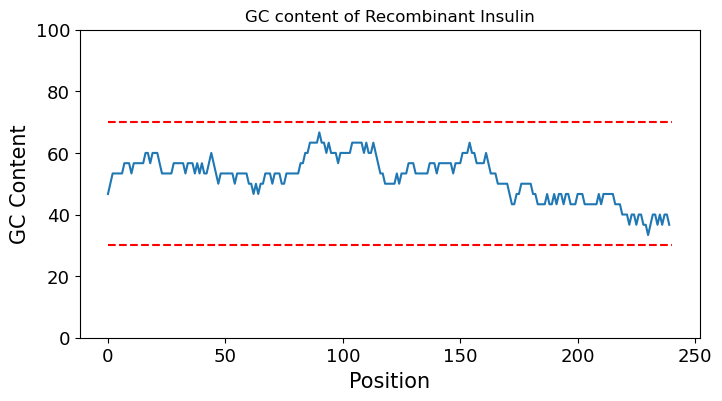

In [ ]:
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=recombinant_insulin_ecoli_dna[:-1])

In [ ]:
file = open('recombinant_insulin_for_ecoli.txt', "a")
a = file.write(opt_codon_seq)
file.close()

For E. Coli,

1. ENC ~ 30~40
2. GC ~ mean 50.4 ~ 50.8%?
3. GC3 ~ mean 40~60 max 0 5? 이게 뭔뜻?
4. CAI ~ 0.38~0.40?
5. CPB ~ 0.08?